In [1]:
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time

%matplotlib inline

TODO

2. Add colour transformations
4. Recompute theta in resize function
5. Test batch time

In [2]:
import tools._init_paths
import dataset
import torch
import torchvision.transforms as transforms
from dataset import custom_transforms

from utils.data_manipulation import add_dist_along_vector, add_dict_perpendicular_vector, rotate_point_by_angle
from utils.data_manipulation import get_object_aligned_box, plot_image_coordinates

In [3]:
from config import cfg
cfg.merge_from_file('experiments/seaturtle/1_test.yaml')

# Custom transforms unit testing

In [4]:
train_dataset = eval('dataset.'+cfg.DATASET.CLASS)(cfg, True, None)
valid_dataset = eval('dataset.'+cfg.DATASET.CLASS)(cfg, False, None)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
train_dataset[0][0].shape, train_dataset[0][1:]

((1350, 2400, 3),
 (1525.0,
  929.6875,
  1591.376458322058,
  408.90043623917643,
  871.3541666666667,
  0.12677062717515852))

In [6]:
from dataset.custom_transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotate, RandomScale, Resize
from dataset.custom_transforms import CropObjectAlignedArea, ResizeKeepRatio

In [7]:
tf_test = { 'Horizontal flip': RandomHorizontalFlip(p=1.), 
            'Vertical flip': RandomVerticalFlip(p=1.),
            'RandomRotations': RandomRotate(degrees=90),
            'RandomScale': RandomScale(scale=(0.8, 1.2)),
            'Resize': Resize(256),
            'ResizeKeepRatio': ResizeKeepRatio(256),
            'CropObjectArea': CropObjectAlignedArea(0., 1.),
}

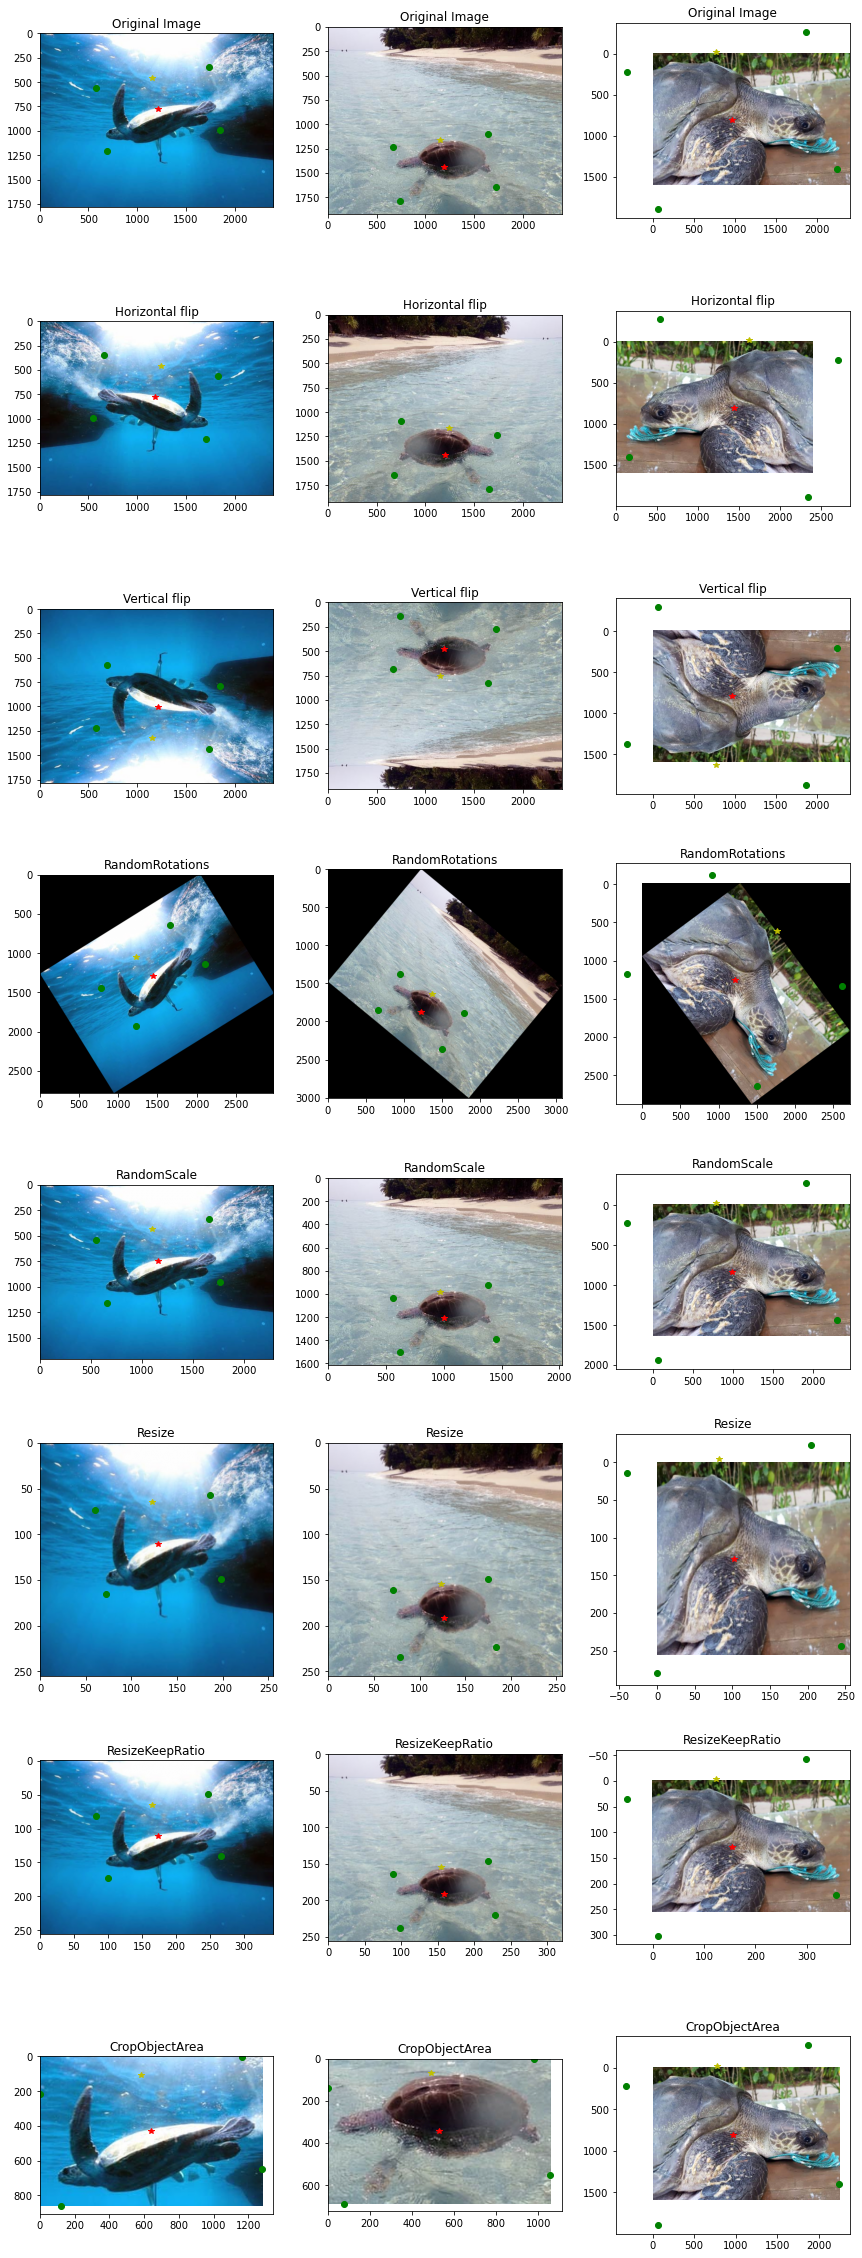

In [8]:
fig, ax = plt.subplots(nrows=len(tf_test)+1, ncols=3, figsize=(3*4, (len(tf_test)+1)*4))
for c in range(3):
    image, xc, yc, xt, yt, w, theta = train_dataset[random.randint(0, len(train_dataset)-1)]
    plot_image_coordinates(ax[0, c], image, xc, yc, xt, yt, w, theta)
    ax[0,c].set_title('Original Image')
    r = 1
    for name, tf in tf_test.items():
        #Apply transformation
        image_, xc_, yc_, xt_, yt_, w_, theta_ = tf((image, xc, yc, xt, yt, w, theta))
        plot_image_coordinates(ax[r, c], image_, xc_, yc_, xt_, yt_, w_, theta_)
        ax[r,c].set_title(name)
        r += 1

plt.tight_layout()

# Test annotations (computed theta vs gt_theta)

In [9]:
from core.evaluate import normalize_theta

In [66]:
def normalize_theta(theta):
    '''Normalize angle theta 
    Input:
        theta (float): angle in degrees
    '''
    if theta >= 360. or theta <= -360.:
        theta = theta % 360 
    
    if theta <=180. and theta > -180.:
        return theta
    
    elif theta > 180.:
        theta -= 360.
        return theta
    
    else:
        theta += 360.
        return theta 

In [71]:
theta_annot_err = []
for i in range(len(train_dataset)):
    xc, yc, xt, yt, w, theta = train_dataset[i][1:]
    theta_computed = math.atan2(yt-yc, xt-xc)
    theta_computed = math.degrees(theta_computed) + 90
    theta_computed = normalize_theta(theta_computed)
    
    theta = normalize_theta(math.degrees(theta))
    
    theta_annot_err.append(abs(theta - theta_computed))
theta_annot_err = np.array(theta_annot_err)

In [73]:
xc, yc, xt, yt, w, theta

(693.75,
 1390.625,
 425.7239761961606,
 233.76792128893317,
 815.625,
 -13.044404334729526)

In [72]:
(theta_annot_err>1).sum()

0

# Data Loader test

In [4]:
train_transform = transforms.Compose([
                        custom_transforms.CropObjectAlignedArea(scale=2.),
                        custom_transforms.ResizeKeepRatio(min_size=600),
                        custom_transforms.RandomHorizontalFlip(p=0.5),
                        custom_transforms.RandomVerticalFlip(p=0.5),        
                        custom_transforms.RandomRotate(degrees=90, mode = 'edge'),
                        custom_transforms.RandomScale(scale=(0.8,1.2)),
                        custom_transforms.CropObjectAlignedArea(noise=0.05),
                        custom_transforms.Resize(cfg.MODEL.IMAGE_SIZE),
                        custom_transforms.ToTensor(),
                        custom_transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                               std =[0.229, 0.224, 0.225],
                                               input_size=cfg.MODEL.IMAGE_SIZE[0])
                        ])

In [5]:
valid_transform = transforms.Compose([
                        #custom_transforms.CropObjectAlignedArea(noise=0.),
                        #custom_transforms.Resize(cfg.MODEL.IMAGE_SIZE),
                        #custom_transforms.ResizeKeepRatio(min_size=256),
                        custom_transforms.ToTensor(),
                        custom_transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                               std =[0.229, 0.224, 0.225],
                                               input_size=cfg.MODEL.IMAGE_SIZE[0])
                        ])

In [6]:
train_dataset = eval('dataset.'+cfg.DATASET.CLASS)(cfg, True, train_transform)
valid_dataset = eval('dataset.'+cfg.DATASET.CLASS)(cfg, False, valid_transform)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=cfg.TRAIN.BS*len(cfg.GPUS),
                                            shuffle=True,
                                            num_workers=cfg.WORKERS,
                                            pin_memory=cfg.PIN_MEMORY
                                        )

In [8]:
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                            batch_size=cfg.TEST.BS*len(cfg.GPUS),
                                            shuffle=False,
                                            num_workers=cfg.WORKERS,
                                            pin_memory=cfg.PIN_MEMORY
                                        )

In [9]:
from utils.utils import unnormalize

In [10]:
%%time
for elem in train_loader:
    start = time.time()
    images, xc, yc, xt, yt, w, theta = elem
    print('proc time {:.3f}s'.format(time.time()-start))
    break

proc time 0.000s
CPU times: user 74.7 ms, sys: 190 ms, total: 265 ms
Wall time: 26.1 s


In [25]:
def save_batch_images(batch_image, coords, theta, file_name, max_cols=8):
    '''
    batch_image: [batch_size, channel, height, width]
    coords: 
    theta: 
    '''
    images_un = unnormalize(batch_image)
    nmaps = batch_image.size(0)
    ncols = min(max_cols, nmaps)
    nrows = int(math.ceil(float(nmaps) / ncols))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
    for r in range(nrows):
        for c in range(ncols):
            plot_image_coordinates(ax[r,c], 
                                   images_un[r*ncols+c].numpy().transpose((1,2,0)), 
                                   coords[r*ncols+c, 0].numpy(), 
                                   coords[r*ncols+c, 1].numpy(), 
                                   coords[r*ncols+c, 2].numpy(), 
                                   coords[r*ncols+c, 3].numpy(), 
                                   coords[r*ncols+c, 4].numpy())
            if theta is not None:
                ax[r,c].set_title('Theta {:.2f}'.format(math.degrees(theta[r*ncols+c])))
    fig.savefig(file_name, format='png', dpi=100, bbox_inches='tight', facecolor='w')

In [20]:
 torch.stack([xc, yc, xt, yt, w], dim=1).shape

torch.Size([4, 5])

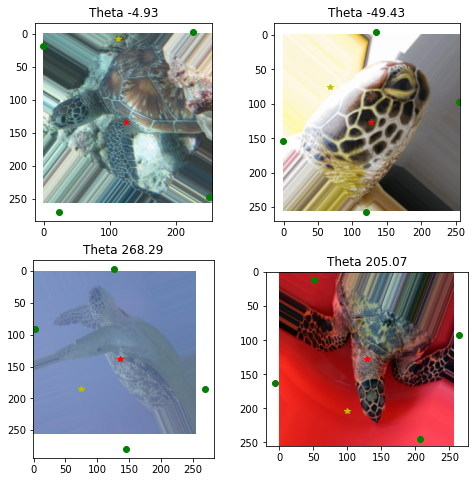

In [26]:
save_batch_images(images, torch.stack([xc, yc, xt, yt, w], dim=1)*256, theta, 'test', max_cols=2)

In [15]:
images_un = unnormalize(images)

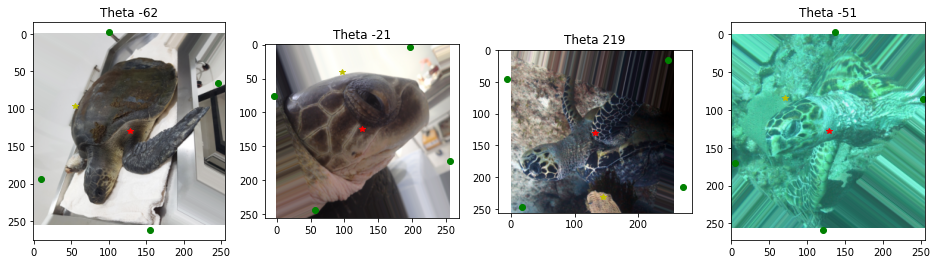

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(4*4, 1*4))
for c in range(4):
    ax[c].imshow(images_un[c].numpy().transpose((1,2,0)))
    plot_image_coordinates(ax[c], 
                           images_un[c].numpy().transpose((1,2,0)), 
                           xc[c].numpy()*cfg.MODEL.IMAGE_SIZE[0], 
                           yc[c].numpy()*cfg.MODEL.IMAGE_SIZE[0], 
                           xt[c].numpy()*cfg.MODEL.IMAGE_SIZE[0], 
                           yt[c].numpy()*cfg.MODEL.IMAGE_SIZE[0], 
                           w[c].numpy()*cfg.MODEL.IMAGE_SIZE[0], 
                           theta[c].numpy())
    ax[c].set_title('Theta {:.0f}'.format(math.degrees(theta[c])))

In [20]:
xc, yc, xt, yt, w, theta

(tensor([0.5000, 0.4922, 0.5156, 0.5039]),
 tensor([0.5078, 0.4844, 0.5117, 0.5000]),
 tensor([0.2148, 0.3750, 0.5625, 0.2773]),
 tensor([0.3750, 0.1562, 0.9023, 0.3281]),
 tensor([0.4221, 0.4150, 0.4980, 0.4241]),
 tensor([-1.0901, -0.3743,  3.8298, -0.8926]))

# Models

TODO

1. Define which layers to retrain: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
2. 

In [19]:
from torchvision import models

In [26]:
core_name = 'resnet50'
model = eval('models.'+core_name)(pretrained=False, progress=True)

In [27]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
t = "Ikya"

In [25]:
t.lower()

'ikya'